In [11]:
# Somme parziali della serie ∑ 1/k^2 in singola precisione (Float32)
function sum_single_precision(N_min::Int, N_max::Int, step::Int)
    
    x_axis = collect(N_min:step:N_max)
    
    values = zeros(Float32, N_max + 1)  # values[1] = 1/1^2, ..., values[N_max] = 1/N_max^2
    for i in 1:N_max
        values[i] = Float32(1 / (i^2))
    end

    sum_crescente   = zeros(Float32, length(x_axis))
    sum_decrescente = zeros(Float32, length(x_axis))

    # Nota: in Python si usa m = 0..n con indexing 0-based.
    # In Julia (1-based) usiamo m = 0..n e accediamo a values[m+1] e values[n-m+1].
    @inbounds for (i, n) in pairs(x_axis)
        sc = 0f0
        sd = 0f0
        for m in 0:n
            sc += values[m + 1]
            sd += values[n - m + 1]
        end
        sum_crescente[i]   = sc
        sum_decrescente[i] = sd
    end

    return sum_crescente, sum_decrescente, x_axis
end

# Somme parziali in doppia precisione (Float64), con n presi da un vettore dato
function sum_double_precision_fixed(n_values::AbstractVector{<:Integer})
    sum_crescente   = zeros(Float64, length(n_values))
    sum_decrescente = zeros(Float64, length(n_values))

    @inbounds for (i, n) in pairs(n_values)
        s1 = 0.0
        for k in 1:n           # crescente: da 1 a n
            s1 += 1.0 / (k^2)
        end
        sum_crescente[i] = s1

        s2 = 0.0
        for k in n:-1:1        # decrescente: da n a 1
            s2 += 1.0 / (k^2)
        end
        sum_decrescente[i] = s2
    end

    return sum_crescente, sum_decrescente
end

# ------------------- Uso come nello script Python -------------------

# Calcolo delle somme (Float32)
a, b, c = 1000, 10000, 50
sum_crescente_32, sum_decrescente_32, x_axis_1 = sum_single_precision(a, b, c)

# Usa valori più ragionevoli per evitare problemi di memoria (Float64)
# np.logspace(7.5, 8.5, 30, dtype=int)  ->  10 .^ range(...), poi arrotondo a Int
x_axis_2 = Int.(round.(10 .^ range(7.5, stop=8.5, length=200)))
sum_crescente_64, sum_decrescente_64 = sum_double_precision_fixed(x_axis_2)

# Calcolo errori rispetto a π^2/6
lim = (π^2) / 6
err_crescente_32   = abs.(Float64.(sum_crescente_32)   .- lim)
err_decrescente_32 = abs.(Float64.(sum_decrescente_32) .- lim)
err_crescente_64   = abs.(sum_crescente_64   .- lim)
err_decrescente_64 = abs.(sum_decrescente_64 .- lim)

# (facoltativo) stampa rapida di controllo
println(("n32_min,max = ", first(x_axis_1), last(x_axis_1)))
println(("n64_min,max = ", minimum(x_axis_2), maximum(x_axis_2)))
println(("err32 cresc/decresc (ultimi): ", err_crescente_32[end], ", ", err_decrescente_32[end]))
println(("err64 cresc/decresc (ultimi): ", err_crescente_64[end], ", ", err_decrescente_64[end]))


("n32_min,max = ", 1000, 10000)
("n64_min,max = ", 31622777, 316227766)
("err32 cresc/decresc (ultimi): ", 0.0002087441248377342, ", ", 0.00010002525276742169)
("err64 cresc/decresc (ultimi): ", 9.013651380840315e-9, ", ", 3.1622775509276835e-9)


In [12]:
using Plots, LaTeXStrings
gr()

default(fontfamily = "Computer Modern",  # Font LaTeX-style
        legendfontsize = 10,
        tickfontsize = 9,
        guidefontsize = 11)


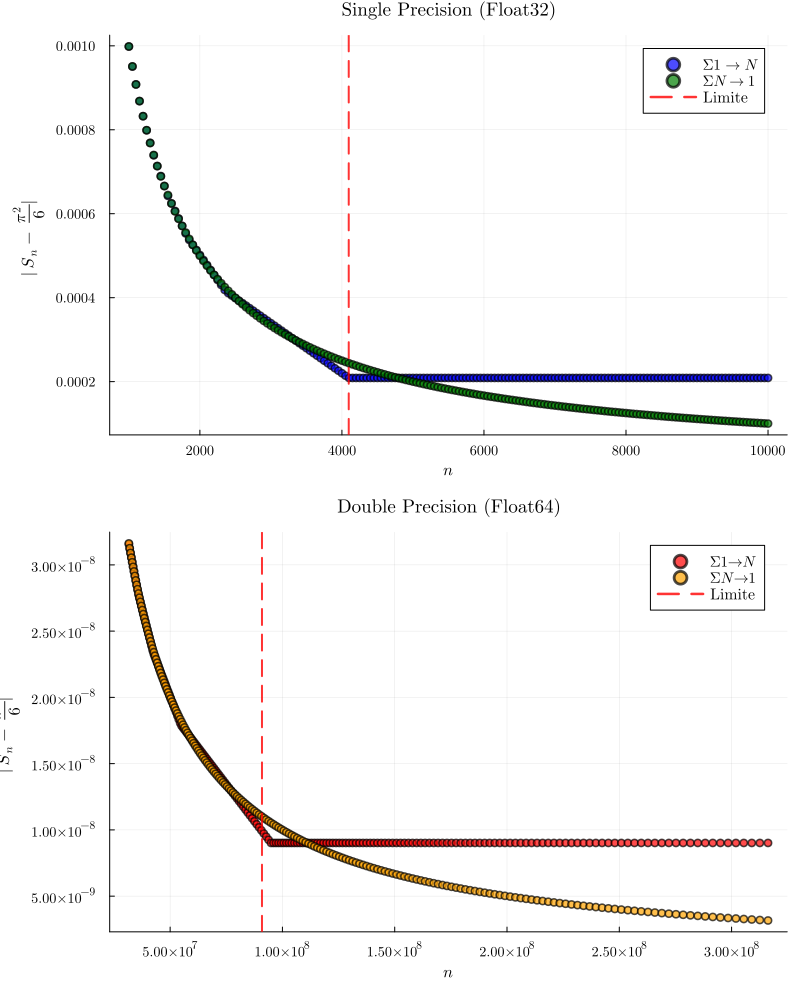

In [29]:

p1 = plot(
    x_axis_1, err_crescente_32,
    seriestype = :scatter,
    label = L"$\Sigma 1 \rightarrow N$",
    color = :blue,
    alpha = 0.7,
)
plot!(p1, x_axis_1, err_decrescente_32,
    seriestype = :scatter,
    label = L"$\Sigma N \rightarrow 1$",
    color = :green,
    alpha = 0.7,
)


# Retta verticale con stile
vline!([4096], 
       color = :red, 
       linestyle = :dash, 
       linewidth = 2, 
       alpha = 0.8,
       label = "Limite")
xlabel!(p1, L"n")
ylabel!(p1, L"|S_n - \frac{\pi^2}{6}|")
title!(p1, "Single Precision (Float32)", titlefont = ("Computer Modern", 12, :bold))

# SECONDO GRAFICO (Float64)
p2 = plot(
    x_axis_2, err_crescente_64,
    seriestype = :scatter,
    label = L"Σ 1→N",
    color = :red,
    alpha = 0.7,
)
plot!(p2, x_axis_2, err_decrescente_64,
    seriestype = :scatter,
    label = L"$Σ N→1$",
    color = :orange,
    alpha = 0.7,
)

# Retta verticale con stile
vline!([90896724], 
       color = :red, 
       linestyle = :dash, 
       linewidth = 2, 
       alpha = 0.8,
       label = "Limite")
xlabel!(p2, L"$n$")
ylabel!(p2, L"$|S_n - \frac{\pi^2}{6}|$")
title!(p2, "Double Precision (Float64)", titlefont = ("Computer Modern", 12, :bold))

# COMBINAZIONE
final_plot = plot(p1, p2, layout = (2, 1), size = (800, 1000))
display(final_plot)

ESERCIZIO 2

In [24]:
# Ricorrenza con tipo parametrico (default: Float64)
function recurrence(N::Integer, ::Type{T}=Float64) where {T<:Real}
    x = zeros(T, N)
    x[1] = T(11) / T(2)
    x[2] = T(61) / T(11)
    for k in 2:N-1
        x[k+1] = T(111) - (T(1130) - T(3000) / x[k-1]) / x[k]
    end
    return x
end

N = 40
x = collect(1:N)
y = recurrence(N, Float64)

# errore rispetto a 6 
err64 = abs.(y .- 6)

# stampa il trentatreesimo elemento della serie
println(y[34])


100.0


In [25]:
using Plots, LaTeXStrings
gr()

default(fontfamily = "Computer Modern",  # Font LaTeX-style
        legendfontsize = 10,
        tickfontsize = 9,
        guidefontsize = 11)

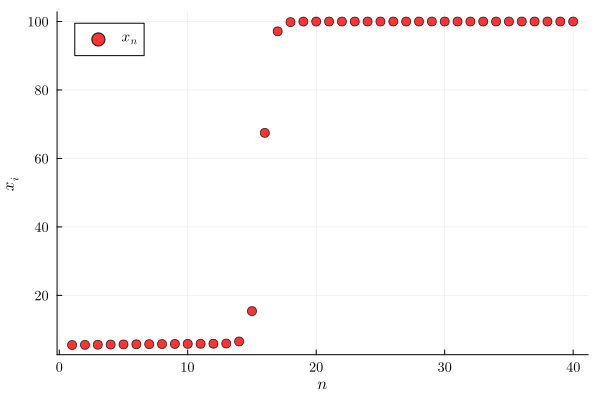

In [27]:
grafico = plot(x, y, 
              seriestype = :scatter, 
              markersize = 5, 
              color = :red, 
              alpha = 0.8, 
              label = L"$x_n$")
xlabel!(grafico, L"$n$")
ylabel!(grafico, L"$x_i$")
display(grafico)

ESERCIZIO 3

In [28]:
function investimento(investimento_iniziale, anni::Int, ::Type{T}=Float64) where {T<:Real}
    capitale = zeros(T, anni + 1)
    capitale[1] = investimento_iniziale
    for k in 2:anni
        capitale[k] = (capitale[k-1] - 1) * (k - 1)
    end
    guadagno_banca = anni
    return capitale, guadagno_banca
end

e_1 = ℯ - 1

capitale = investimento(e_1, 25, Float64)[1]
guadagno_banca = investimento(e_1, 25, Float64)[2]

println(capitale)
println(guadagno_banca)


[1.718281828459045, 0.7182818284590451, -0.5634363430819098, -4.6903090292457295, -22.761236116982918, -118.80618058491459, -718.8370835094875, -5038.859584566412, -40318.8766765313, -362878.89008878166, -3.6287989008878167e6, -3.991679890976598e7, -4.7900159891719174e8, -6.227020798923492e9, -8.71782911989289e10, -1.3076743679989333e12, -2.0922789887998934e13, -3.556874280959989e14, -6.402373705727998e15, -1.2164510040883198e17, -2.4329020081766395e18, -5.109094217170943e19, -1.1240007277776075e21, -2.5852016738884974e22, -6.204484017332394e23, 0.0]
25
